In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os import listdir

In [3]:
data_path = r'C:/Users/admin/OneDrive/Desktop/Arrihythmia/mit-bih-arrhythmia-database-1.0.0/'

In [4]:
# list of patients
pts = ['100','101','102','103','104','105','106','107',
       '108','109','111','112','113','114','115','116',
       '117','118','119','121','122','123','124','200',
       '201','202','203','205','207','208','209','210',
       '212','213','214','215','217','219','220','221',
       '222','223','228','230','231','232','233','234']

In [5]:
!pip install wfdb

In [6]:
import wfdb

In [7]:
# Loading all the annotations and see the distribution of heart beat types across all files.
df = pd.DataFrame()

for pt in pts:
    file = data_path + pt
    annotation = wfdb.rdann(file, 'atr')
    sym = annotation.symbol
    
    values, counts = np.unique(sym, return_counts=True)
    df_sub = pd.DataFrame({'sym':values, 'val':counts, 'pt':[pt]*len(counts)})
    df = pd.concat([df, df_sub],axis = 0)

In [8]:
df.groupby('sym').val.sum().sort_values(ascending = False)

sym
N    75052
L     8075
R     7259
V     7130
/     7028
A     2546
+     1291
f      982
F      803
~      616
!      472
"      437
j      229
x      193
a      150
|      132
E      106
J       83
Q       33
e       16
[        6
]        6
S        2
Name: val, dtype: int64

In [9]:
# list of nonbeat and abnormal
nonbeat = ['[','!',']','x','(',')','p','t','u','`',
           '\'','^','|','~','+','s','T','*','D','=','"','@','Q','?']
abnormal = ['L','R','V','/','A','f','F','j','a','E','J','e','S']

In [10]:
# categorizing into normal, abnormal or nonbeat   
df['category'] = -1
df.loc[df.sym == 'N','category'] = 0
df.loc[df.sym.isin(abnormal), 'category'] = 1

In [11]:
df.groupby('category').val.sum()

category
-1     3186
 0    75052
 1    34409
Name: val, dtype: int64

In [12]:
def load_ecg(file):
    # load the ecg
    # example file: 'mit-bih-arrhythmia-database-1.0.0/101'
    
    # load the ecg
    record = wfdb.rdrecord(file)                # wfdb.rdrecord: Read a WFDB record and return the signal and record descriptors as attributes in a Record or MultiRecord object.
    # load the annotation
    annotation = wfdb.rdann(file, 'atr')        # wfdb.rdann: Read a WFDB annotation file record_name.extension and return an Annotation object.
    
    # extract the signal
    p_signal = record.p_signal                 # signals in physical units in the p_signal field (True), or digital units in the d_signal field (False).
    #the d_signals and p_signals attributes store the digital and physical signals of WFDB records with at least one channel.
    #p_signals (default=None): An MxN 2d numpy array, where M is the signal length. Gives the physical signal values intended to be written. Either p_signals or d_signals must be set, but not both. If p_signals is set, this method will use it to perform analogue-digital conversion, writing the resultant digital values to the dat file(s)
    
    # verify frequency is 360
    assert record.fs == 360, 'sample freq is not 360'
    
    # extract symbols and annotation index
    atr_sym = annotation.symbol
    atr_sample = annotation.sample
    
    return p_signal, atr_sym, atr_sample 

In [13]:
file = data_path + pts[0]
p_signal, atr_sym, atr_sample = load_ecg(file)

In [14]:
values, counts = np.unique(sym, return_counts=True)
for v,c in zip(values, counts):
    print(v,c)

+ 3
J 50
N 2700
V 3
~ 8


In [15]:
# get abnormal beat index
ab_index = [b for a,b in zip(atr_sym,atr_sample) if a in abnormal][:10]
ab_index

[2044, 66792, 74986, 99579, 128085, 170719, 279576, 305709, 307745, 312825]

In [16]:
x = np.arange(len(p_signal))

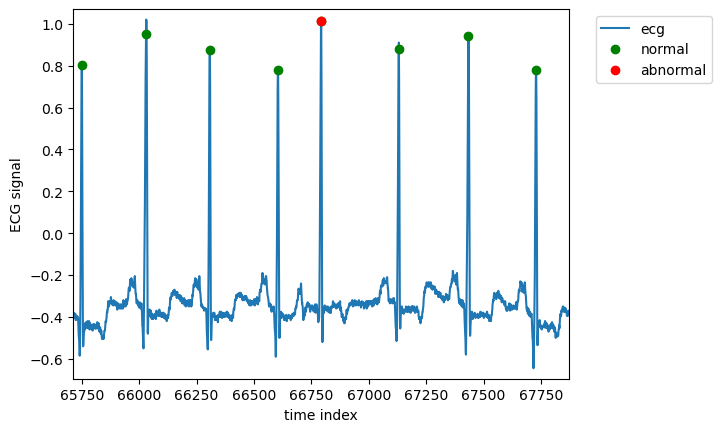

In [17]:
left = ab_index[1]-1080
right = ab_index[1]+1080

plt.plot(x[left:right],p_signal[left:right,0],'-',label='ecg',)
plt.plot(x[atr_sample],p_signal[atr_sample,0],'go',label ='normal')
plt.plot(x[ab_index],p_signal[ab_index,0],'ro',label='abnormal')

plt.xlim(left,right)
plt.ylim(p_signal[left:right].min()-0.05,p_signal[left:right,0].max()+0.05)
plt.xlabel('time index')
plt.ylabel('ECG signal')
plt.legend(bbox_to_anchor = (1.04,1), loc = 'upper left')
plt.show()

In [18]:
def make_dataset(pts, num_sec, fs, abnormal):
    # function for making dataset ignoring non-beats
    # input:
    # pts - list of patients
    # num_sec = number of seconds to include before and after the beat
    # fs = frequency
    # output: 
    #   X_all = signal (nbeats , num_sec * fs columns)
    #   Y_all = binary is abnormal (nbeats, 1)
    #   sym_all = beat annotation symbol (nbeats,1)
    
    # initialize numpy arrays
    num_cols = 2*num_sec * fs
    X_all = np.zeros((1,num_cols))
    Y_all = np.zeros((1,1))
    sym_all = []
    
    # list to keep track of number of beats across patients
    max_rows = []
    
    for pt in pts:
        file = data_path + pt
        
        p_signal, atr_sym, atr_sample = load_ecg(file)
        
        # grab the first signal
        p_signal = p_signal[:,0]
        
        # make df to exclude the nonbeats
        df_ann = pd.DataFrame({'atr_sym':atr_sym,
                              'atr_sample':atr_sample})
        df_ann = df_ann.loc[df_ann.atr_sym.isin(abnormal + ['N'])]
        
        X,Y,sym = build_XY(p_signal,df_ann, num_cols, abnormal)
        sym_all = sym_all+sym
        max_rows.append(X.shape[0])
        X_all = np.append(X_all,X,axis = 0)
        Y_all = np.append(Y_all,Y,axis = 0)
    # drop the first zero row
    X_all = X_all[1:,:]
    Y_all = Y_all[1:,:]
    
    # check sizes make sense
    assert np.sum(max_rows) == X_all.shape[0], 'number of X, max_rows rows messed up'
    assert Y_all.shape[0] == X_all.shape[0], 'number of X, Y rows messed up'
    assert Y_all.shape[0] == len(sym_all), 'number of Y, sym rows messed up'

    return X_all, Y_all, sym_all



def build_XY(p_signal, df_ann, num_cols, abnormal):
    # this function builds the X,Y matrices for each beat
    # it also returns the original symbols for Y
    
    num_rows = len(df_ann)

    X = np.zeros((num_rows, num_cols))
    Y = np.zeros((num_rows,1))
    sym = []
    
    # keep track of rows
    max_row = 0

    for atr_sample, atr_sym in zip(df_ann.atr_sample.values,df_ann.atr_sym.values):

        left = max([0,(atr_sample - num_sec*fs) ])
        right = min([len(p_signal),(atr_sample + num_sec*fs) ])
        x = p_signal[left: right]
        if len(x) == num_cols:
            X[max_row,:] = x
            Y[max_row,:] = int(atr_sym in abnormal)
            sym.append(atr_sym)
            max_row += 1
    X = X[:max_row,:]
    Y = Y[:max_row,:]
    return X,Y,sym

In [19]:
num_sec = 3
fs = 360

In [20]:
X_all, Y_all, sym_all = make_dataset(pts, num_sec, fs, abnormal)

In [21]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X_all, Y_all, test_size=0.30, random_state=42)

In [22]:
X_train.shape[1]

2160

In [23]:
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score
def calc_prevalence(y_actual):
    return (sum(y_actual)/len(y_actual))
def calc_specificity(y_actual, y_pred, thresh):
    # calculates specificity
    return sum((y_pred < thresh) & (y_actual == 0)) /sum(y_actual ==0)
def print_report(y_actual, y_pred, thresh):
    
    auc = roc_auc_score(y_actual, y_pred)
    accuracy = accuracy_score(y_actual, (y_pred > thresh))
    recall = recall_score(y_actual, (y_pred > thresh))
    precision = precision_score(y_actual, (y_pred > thresh))
    specificity = calc_specificity(y_actual, y_pred, thresh)
    print('AUC:%.3f'%auc)
    print('accuracy:%.3f'%accuracy)
    print('recall:%.3f'%recall)
    print('precision:%.3f'%precision)
    print('specificity:%.3f'%specificity)
    print('prevalence:%.3f'%calc_prevalence(y_actual))
    print(' ')
    return auc, accuracy, recall, precision, specificity

In [24]:
pip install keras

Note: you may need to restart the kernel to use updated packages.


In [25]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [26]:
#CNN

from keras.layers import Conv1D
from keras.models import Sequential
from keras.layers import  Dropout, Flatten, Dense

# reshape input to be [samples, time steps, features = 1]

X_train_cnn = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_valid_cnn = np.reshape(X_valid, (X_valid.shape[0], X_valid.shape[1], 1))

print(X_train_cnn.shape)
print(X_valid_cnn.shape)

model = Sequential()
model.add(Conv1D(filters = 128, kernel_size = 5, activation = 'relu', input_shape = (2160,1)))
model.add(Dropout(rate = 0.25))
model.add(Flatten())
model.add(Dense(1, activation = 'sigmoid'))

# compile the model - use categorical crossentropy, and the adam optimizer
model.compile(
                loss = 'binary_crossentropy',
                optimizer = 'adam',
                metrics = ['accuracy'])

(76369, 2160, 1)
(32730, 2160, 1)


In [27]:
X_train.shape

(76369, 2160)

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 2156, 128)         768       
                                                                 
 dropout (Dropout)           (None, 2156, 128)         0         
                                                                 
 flatten (Flatten)           (None, 275968)            0         
                                                                 
 dense (Dense)               (None, 1)                 275969    
                                                                 
Total params: 276,737
Trainable params: 276,737
Non-trainable params: 0
_________________________________________________________________


In [29]:
y_train_preds_cnn = model.predict(X_train_cnn,verbose = 1)

2387/2387 [==============================] - 138s 55ms/step


In [30]:
y_valid_preds_cnn = model.predict(X_valid_cnn,verbose = 1)

1023/1023 [==============================] - 57s 55ms/step


In [31]:
thresh = (sum(y_train)/len(y_train))[0]
thresh

0.31438148987154474

In [32]:
print('Train')
print_report(y_train, y_train_preds_cnn, thresh)

Train
AUC:0.437
accuracy:0.314
recall:1.000
precision:0.314
specificity:0.000
prevalence:0.314
 


(0.4372688903807749,
 0.31438148987154474,
 1.0,
 0.31438148987154474,
 array([0.]))

In [33]:
print('Valid')
print_report(y_valid, y_valid_preds_cnn, thresh)

Valid
AUC:0.436
accuracy:0.315
recall:1.000
precision:0.315
specificity:0.000
prevalence:0.315
 


(0.4363740590836427, 0.3145432325084021, 1.0, 0.3145432325084021, array([0.]))

In [34]:
#LSTM


X_train_LSTM = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_valid_LSTM = np.reshape(X_valid, (X_valid.shape[0], X_valid.shape[1], 1))

print(X_train_LSTM.shape)
print(X_valid_LSTM.shape)

(76369, 2160, 1)
(32730, 2160, 1)


In [35]:
#LSTM

from keras.layers import Bidirectional, LSTM
model = Sequential()
model.add(Bidirectional(LSTM(64, input_shape=(X_train_cnn.shape[1], X_train_cnn.shape[2]))))
model.add(Dropout(rate = 0.25))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(
                loss = 'binary_crossentropy',
                optimizer = 'adam',
                metrics = ['accuracy'])

In [36]:
model.fit(X_train_cnn, y_train, batch_size = 32, epochs= 2, verbose = 1)

Epoch 1/2
2387/2387 [==============================] - 5390s 2s/step - loss: 0.6144 - accuracy: 0.6859
Epoch 2/2
2387/2387 [==============================] - 5212s 2s/step - loss: 0.6114 - accuracy: 0.6913


In [37]:
y_train_preds_lstm = model.predict(X_train_cnn,verbose = 1)
y_valid_preds_lstm = model.predict(X_valid_cnn,verbose = 1)

1023/1023 [==============================] - 438s 426ms/step


In [38]:
print('Train');
print_report(y_train, y_train_preds_lstm, thresh)
print('Valid');
print_report(y_valid, y_valid_preds_lstm, thresh);

Train
AUC:0.573
accuracy:0.644
recall:0.251
precision:0.395
specificity:0.823
prevalence:0.314
 
Valid
AUC:0.576
accuracy:0.645
recall:0.255
precision:0.400
specificity:0.825
prevalence:0.315
 


In [ ]:
# Normalize the data to have zero mean and unit variance
#X_normalized = (X_resampled - np.mean(X_resampled)) / np.std(X_resampled)


In [ ]:
# Apply data augmentation by adding Gaussian noise
#noise = np.random.normal(0, 0.05, X_normalized.shape)
#X_augmented = X_normalized + noise

In [ ]:
# Combine the features and labels into a single array
#data_processed = np.column_stack((X_augmented, y))

# Save the processed data to a new file
#np.save('mitbih_processed.npy', data_processed)

In [ ]:
# Split the data into training and testing sets
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [40]:
#RNN

from tensorflow.keras import layers, models
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN

model = Sequential()
model.add(SimpleRNN(units=128, input_shape=(2160, 1)))
model.add(Dense(units=1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=2, validation_data=(X_train, y_train))



Epoch 1/2
2387/2387 [==============================] - 1691s 705ms/step - loss: 0.6293 - accuracy: 0.6779 - val_loss: 0.6249 - val_accuracy: 0.6855
Epoch 2/2
2387/2387 [==============================] - 1976s 827ms/step - loss: 0.6206 - accuracy: 0.6859 - val_loss: 0.6196 - val_accuracy: 0.6862


In [41]:
y_train_preds_RNN = model.predict(X_train_cnn,verbose = 1)
y_valid_preds_RNN = model.predict(X_valid_cnn,verbose = 1)

1023/1023 [==============================] - 288s 282ms/step


In [42]:
print('Train');
print_report(y_train, y_train_preds_RNN, thresh)
print('Valid');
print_report(y_valid, y_valid_preds_RNN, thresh);

Train
AUC:0.556
accuracy:0.629
recall:0.244
precision:0.365
specificity:0.805
prevalence:0.314
 
Valid
AUC:0.557
accuracy:0.631
recall:0.247
precision:0.370
specificity:0.807
prevalence:0.315
 


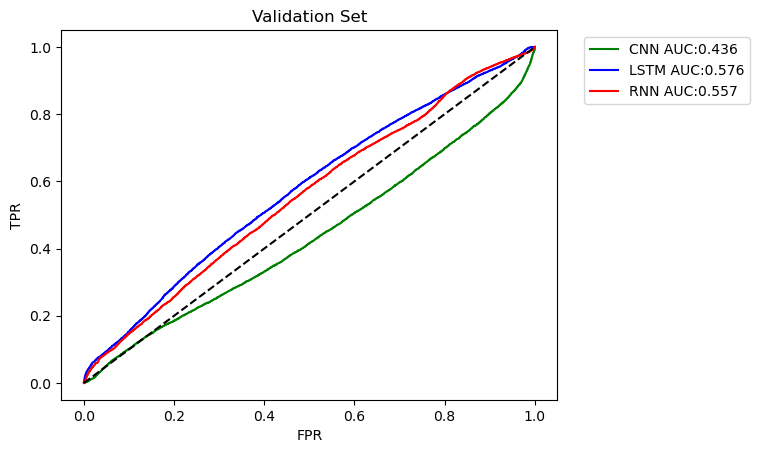

In [44]:
from sklearn.metrics import roc_curve, roc_auc_score


fpr_valid_cnn, tpr_valid_cnn, t_valid_cnn = roc_curve(y_valid, y_valid_preds_cnn)
auc_valid_cnn = roc_auc_score(y_valid, y_valid_preds_cnn)

fpr_valid_lstm, tpr_valid_lstm, t_valid_lstm = roc_curve(y_valid, y_valid_preds_lstm)
auc_valid_lstm = roc_auc_score(y_valid, y_valid_preds_lstm)

fpr_valid_RNN, tpr_valid_RNN, t_valid_RNN = roc_curve(y_valid, y_valid_preds_RNN)
auc_valid_RNN = roc_auc_score(y_valid, y_valid_preds_RNN)

plt.plot(fpr_valid_cnn, tpr_valid_cnn, 'g-', label = 'CNN AUC:%.3f'%auc_valid_cnn)
plt.plot(fpr_valid_lstm, tpr_valid_lstm, 'b-', label = 'LSTM AUC:%.3f'%auc_valid_lstm)
plt.plot(fpr_valid_RNN, tpr_valid_RNN, 'r-', label = 'RNN AUC:%.3f'%auc_valid_RNN)

plt.plot([0,1],[0,1], 'k--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend(bbox_to_anchor = (1.04,1), loc = 'upper left')
plt.title('Validation Set')
plt.show()